In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import KFold
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from contextlib import contextmanager # timer
from functools import partial
import cv2
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pylab as plt
from sklearn.model_selection import KFold
import random
from skimage.transform import rescale, resize
from scipy.ndimage import rotate
import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
import SimpleITK as sitk
print(os.listdir("../input/"))
from skimage import data, img_as_float
from skimage import exposure
from sklearn.metrics import jaccard_score
import time
import random

from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Multiply, Dense, Conv2D, UpSampling2D, add, MaxPooling2D, BatchNormalization, Dropout, concatenate, GlobalAveragePooling2D
from keras import Model, Input
from keras.layers import Dense, Dropout,Input,Average,Conv2DTranspose,SeparableConv2D,dot,UpSampling2D,Add, Flatten,Concatenate,Multiply,Conv2D, MaxPooling2D,Activation,AveragePooling2D, ZeroPadding2D,GlobalAveragePooling2D,multiply,DepthwiseConv2D,ZeroPadding2D,GlobalAveragePooling2D,concatenate ,Lambda

['unet_0002_50', 'preprocessing-kvasir-dataset', 'data-split', 'kvasirseg']


2024-10-08 07:40:15.912888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 07:40:15.913047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 07:40:16.056277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATA PRE-PROCESSING (SPECULARITIES REMOVAL)

In [2]:
def derive_graym(impath):
    ''' The intensity value m is calculated as (r+g+b)/3, yet 
        grayscalse will do same operation!
        opencv uses default formula Y = 0.299 R + 0.587 G + 0.114 B
    '''
    # return cv2.imread(impath, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    img = cv2.imread(impath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR )
    return img

def derive_m(img, rimg):
    ''' Derive m (intensity) based on paper formula '''

    (rw, cl, ch) = img.shape
    for r in range(rw):
        for c in range(cl):
            rimg[r,c] = int(np.sum(img[r,c])/3.0)
            
    return rimg

def derive_saturation(img, rimg):
    ''' Derive staturation value for a pixel based on paper formula '''

    s_img = np.array(rimg)
    (r, c) = s_img.shape
    for ri in range(r):
        for ci in range(c):
            #opencv ==> b,g,r order
            s1 = np.clip(img[ri,ci][0] + img[ri,ci][2],0,255)
            s2 = 2 * img[ri,ci][1] 
            if  s1 >=  s2:
                s_img[ri,ci] = 1.5*np.clip((img[ri,ci][2] - rimg[ri,ci]),0,255)
            else:
                s_img[ri,ci] = 1.5*np.clip((rimg[ri,ci] - img[ri,ci][0]),0,255)

    return s_img

def check_pixel_specularity(mimg, simg):
    ''' Check whether a pixel is part of specular region or not'''

    m_max = np.max(mimg) * 0.5
    s_max = np.max(simg) * 0.33

    (rw, cl) = simg.shape

    spec_mask = np.zeros((rw,cl), dtype=np.uint8)
    for r in range(rw):
        for c in range(cl):
            if mimg[r,c] >= m_max and simg[r,c] <= s_max:
                spec_mask[r,c] = 255
    
    return spec_mask

def enlarge_specularity(spec_mask):
    ''' Use sliding window technique to enlarge specularity
        simply move window over the image if specular pixel detected
        mark center pixel is specular
        win_size = 3x3, step_size = 1
    '''

    win_size, step_size = (3,3), 1
    enlarged_spec = np.array(spec_mask)
    for r in range(0, spec_mask.shape[0], step_size):
        for c in range(0, spec_mask.shape[1], step_size):
            # yield the current window
            win = spec_mask[r:r + win_size[1], c:c + win_size[0]]
            
            if win.shape[0] == win_size[0] and win.shape[1] == win_size[1]:
                if win[1,1] !=0:
                    enlarged_spec[r:r + win_size[1], c:c + win_size[0]] = 255 * np.ones((3,3), dtype=np.uint8)

    return enlarged_spec 

In [3]:
impath = '/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg'
img = cv2.imread(impath)
img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR )
gray_img = derive_graym(impath)
r_img = m_img = np.array(gray_img)

rimg = derive_m(img, r_img)
s_img = derive_saturation(img, rimg)
spec_mask = check_pixel_specularity(rimg, s_img)
enlarged_spec = enlarge_specularity(spec_mask)

/tmp/ipykernel_34/363194163.py:34: RuntimeWarning: overflow encountered in scalar subtract
  s_img[ri,ci] = 1.5*np.clip((rimg[ri,ci] - img[ri,ci][0]),0,255)
/tmp/ipykernel_34/363194163.py:29: RuntimeWarning: overflow encountered in scalar add
  s1 = np.clip(img[ri,ci][0] + img[ri,ci][2],0,255)
/tmp/ipykernel_34/363194163.py:32: RuntimeWarning: overflow encountered in scalar subtract
  s_img[ri,ci] = 1.5*np.clip((img[ri,ci][2] - rimg[ri,ci]),0,255)


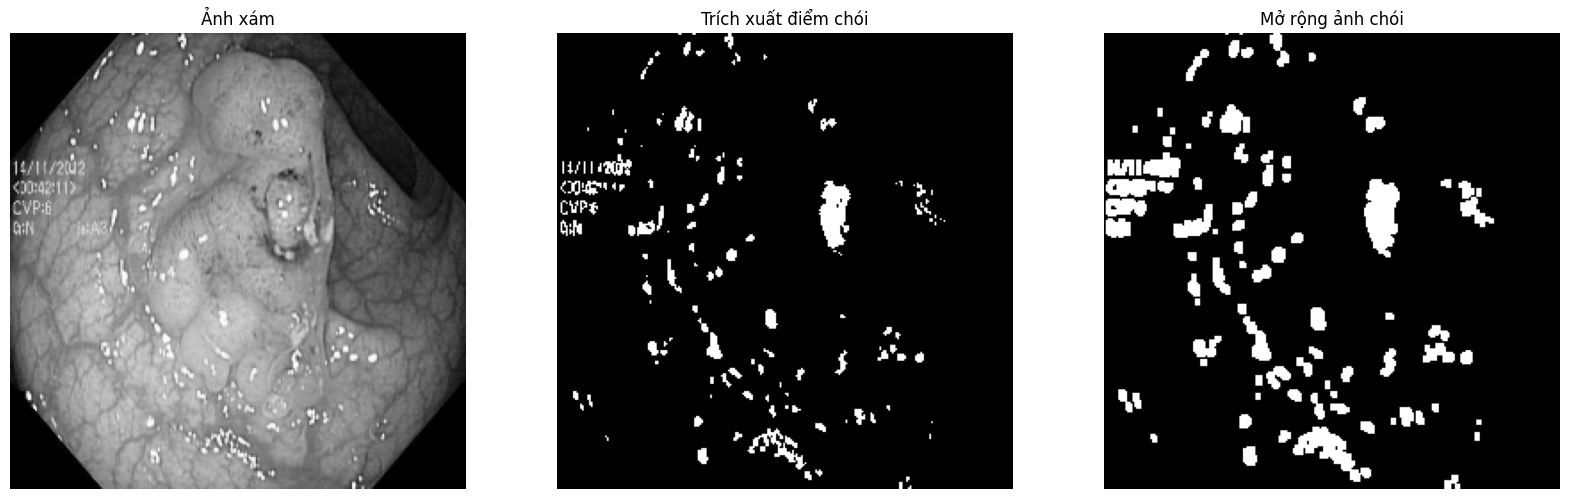

In [4]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh xám')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(spec_mask, cv2.COLOR_BGR2RGB))
plt.title('Trích xuất điểm chói')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(enlarged_spec, cv2.COLOR_BGR2RGB))
plt.title('Mở rộng ảnh chói')
plt.axis('off')
plt.show()

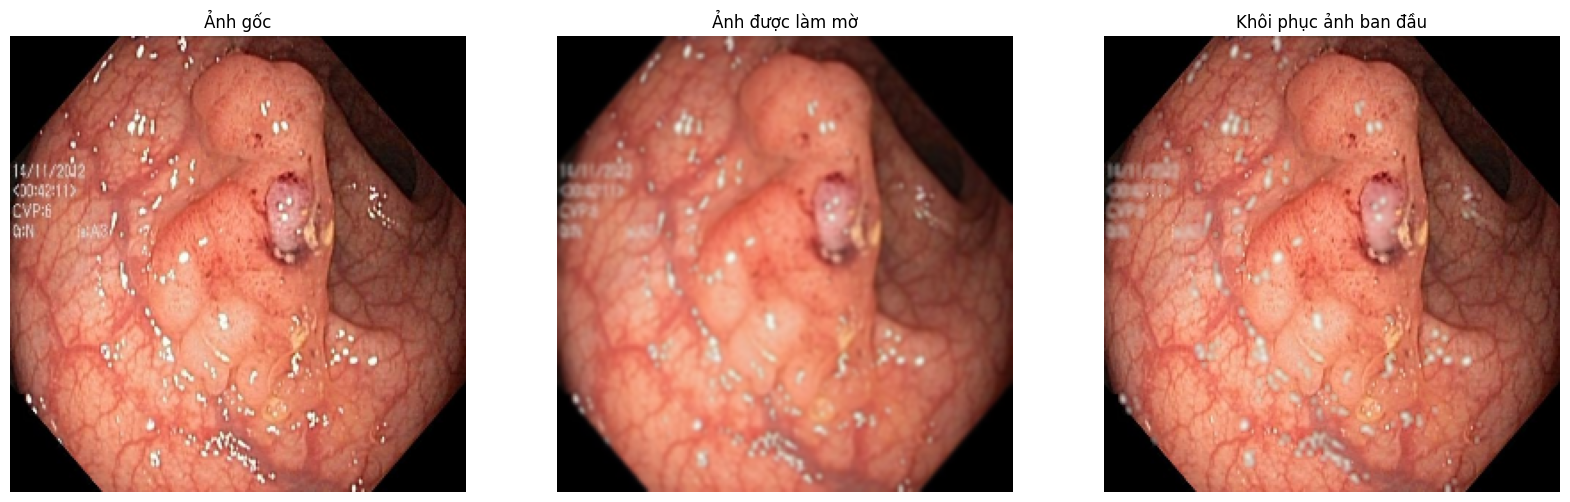

In [5]:
img_blur = cv2.GaussianBlur(img,(5,5), 0)
_, specular_mask_binary = cv2.threshold(enlarged_spec, 127, 255, cv2.THRESH_BINARY)
specular_mask_binary = specular_mask_binary.astype(bool)

image_restore = img.copy()
image_restore[specular_mask_binary] = img_blur[specular_mask_binary]


plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh gốc')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.title('Ảnh được làm mờ')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(image_restore, cv2.COLOR_BGR2RGB))
plt.title('Khôi phục ảnh ban đầu')
plt.axis('off')
plt.show()

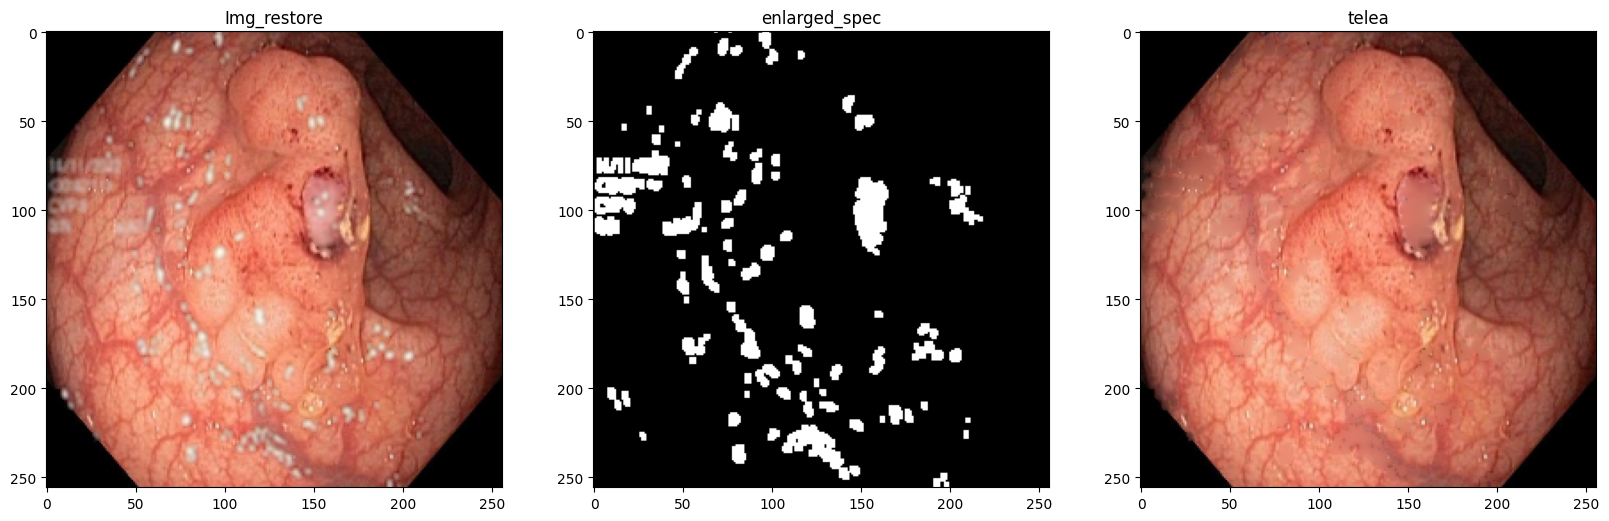

In [6]:
radius = 20
telea = cv2.inpaint(image_restore, enlarged_spec, radius, cv2.INPAINT_TELEA)
# ns = cv2.inpaint(img, enlarged_spec, radius, cv2.INPAINT_NS)

plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.imshow(cv2.cvtColor(image_restore, cv2.COLOR_BGR2RGB))
plt.title('Img_restore')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(enlarged_spec, cv2.COLOR_BGR2RGB))
plt.title('enlarged_spec')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(telea, cv2.COLOR_BGR2RGB))
plt.title('telea')

plt.show()

In [ ]:
# cv2.imwrite(f'/kaggle/working/anh_goc.jpg', img)
# cv2.imwrite(f'/kaggle/working/gray_img.jpg', gray_img)
# cv2.imwrite(f'/kaggle/working/spec_mask.jpg', spec_mask)
# cv2.imwrite(f'/kaggle/working/enlarged_spec.jpg', enlarged_spec)
# cv2.imwrite(f'/kaggle/working/image_restore.jpg', image_restore)
# cv2.imwrite(f'/kaggle/working/img_blur.jpg', img_blur)

# # cv2.imwrite(f'/kaggle/working/telea.jpg', telea)

#### SAVE DATA PREP

In [ ]:
# import os
# os.makedirs('/kaggle/working/polyp_SR')
# file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))

# count = 0
# path = '/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/'
# radius = 20
    
# for i in file_list:
#     print('\r'f"{count}", end='\t')
#     # read image
#     img = cv2.imread(path + i)
#     img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR )
    
#     # read img gray
#     gray_img = derive_graym(path + i)
#     r_img = m_img = np.array(gray_img)
    
#     # spec detect
#     rimg = derive_m(img, r_img)
#     s_img = derive_saturation(img, rimg)
#     spec_mask = check_pixel_specularity(rimg, s_img)
#     enlarged_spec = enlarge_specularity(spec_mask)
    
#     # smooth
#     img_blur = cv2.GaussianBlur(img,(7,7), 0)
#     _, specular_mask_binary = cv2.threshold(enlarged_spec, 127, 255, cv2.THRESH_BINARY)
#     specular_mask_binary = specular_mask_binary.astype(bool)
    
#     image_restore = img.copy()
#     image_restore[specular_mask_binary] = img_blur[specular_mask_binary]
    
#     # telea alog
#     telea = cv2.inpaint(image_restore, enlarged_spec, radius, cv2.INPAINT_TELEA)
    
#     # write to folder
#     cv2.imwrite(f'/kaggle/working/polyp_SR/{i}', telea)
#     count = count + 1

# DATA GENERATION

In [ ]:
def batch_generator(batch_size, gen_x): 
    batch_features = np.zeros((batch_size,256,256,3))
    batch_labels = np.zeros((batch_size,256,256,3)) 
    while True:
        for i in range(batch_size):
            batch_features[i] , batch_labels[i] = next(gen_x)
        yield batch_features, batch_labels

In [ ]:
def generate_data(filelist, img_path, mask_path):
    while True:
        for i in filelist:
            X_train = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            X_train = cv2.resize(X_train, (256,256), interpolation= cv2.INTER_LINEAR ) # zzzz
            
            y_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
            y_mask = cv2.resize(y_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_train = (y_mask/255).astype(int)
            
            yield X_train, y_train

In [ ]:
def generate_data_pred(filelist, img_path, mask_path, gen_type = "train"):
    while True:
        for i in filelist:
            original_img = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            X_train = cv2.resize(original_img, (256,256), interpolation= cv2.INTER_LINEAR )

            
            original_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
#             original_mask = cv2.resize(original_mask, (256,256), interpolation= cv2.INTER_LINEAR) # data prep
    
            _,original_mask = cv2.threshold(original_mask, 127, 255, cv2.THRESH_BINARY)
            
            y_mask = cv2.resize(original_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_mask = (y_mask/255).astype(int)
            yield original_img, original_mask, X_train, y_mask

# LOSS FUNC & METRICS

In [ ]:
import tensorflow.keras.backend as K
from keras.layers import Flatten

def dice_score(mask_gt, mask_pred):
    """Computes soerensen-dice coefficient.

    compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
    and the predicted mask `mask_pred`.

    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum 


def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:

def jacard_coef(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)

In [ ]:
# # Computing Sensitivity      
# def sensitivity(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
    
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())


# # Computing Specificity
# def specificity(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
    
#     true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
#     return true_negatives / (possible_negatives + K.epsilon())

# MODEL

#### U-NET

In [ ]:
def Unet(img_size, num_classes):

    inputs = tf.keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

#### UNET_EX_V3

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def attention_gate(input_1, input_2, filters):
    g1 = Conv2D(filters, 1, strides=1, padding='same')(input_1)
    x1 = Conv2D(filters, 1, strides=1, padding='same')(input_2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Concatenate(axis=-1)([g1, x1])
    x1 = Conv2D(1, 1, activation='sigmoid', padding='same')(x1)
    return x1

def conv_block(input_tensor, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def UNet_eTuan(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Center
    center = conv_block(pool4, 1024)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(center)
    up4 = Conv2D(512, 2, activation='relu', padding='same')(up4)
    att4 = attention_gate(conv4, up4, 512)
    merge4 = Concatenate()([conv4, att4])
    up_conv4 = conv_block(merge4, 512)

    up3 = UpSampling2D(size=(2, 2))(up_conv4)
    up3 = Conv2D(256, 2, activation='relu', padding='same')(up3)
    att3 = attention_gate(conv3, up3, 256)
    merge3 = Concatenate()([conv3, att3])
    up_conv3 = conv_block(merge3, 256)

    up2 = UpSampling2D(size=(2, 2))(up_conv3)
    up2 = Conv2D(128, 2, activation='relu', padding='same')(up2)
    att2 = attention_gate(conv2, up2, 128)
    merge2 = Concatenate()([conv2, att2])
    up_conv2 = conv_block(merge2, 128)

    up1 = UpSampling2D(size=(2, 2))(up_conv2)
    up1 = Conv2D(64, 2, activation='relu', padding='same')(up1)
    att1 = attention_gate(conv1, up1, 64)
    merge1 = Concatenate()([conv1, att1])
    up_conv1 = conv_block(merge1, 64)

    # Output
    outputs = Conv2D(num_classes, 3, activation='sigmoid', padding ='same')(up_conv1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

#### DUCK-NET

In [ ]:
kernel_initializer = 'he_uniform'
def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result

def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)

    x3 = conv_block_2D(x, filters, 'resnet', repeat=1)

    x4 = conv_block_2D(x, filters, 'resnet', repeat=2)

    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)

    x6 = separated_conv2D_block(x, filters, size=6, padding='same')

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalization(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final


def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

In [ ]:
interpolation = "nearest"

def ducknet(img_size, num_classes):
    input_layer = Input(shape=img_size + (3,))

    p1 = Conv2D(32 * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(32 * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(32 * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(32 * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(32 * 32, 2, strides=2, padding='same')(p4)

    t0 = conv_block_2D(input_layer, 32, 'duckv2', repeat=1)

    l1i = Conv2D(32 * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = conv_block_2D(s1, 32 * 2, 'duckv2', repeat=1)

    l2i = Conv2D(32 * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = conv_block_2D(s2, 32 * 4, 'duckv2', repeat=1)

    l3i = Conv2D(32 * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = conv_block_2D(s3, 32 * 8, 'duckv2', repeat=1)

    l4i = Conv2D(32 * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = conv_block_2D(s4, 32 * 16, 'duckv2', repeat=1)

    l5i = Conv2D(32 * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = conv_block_2D(s5, 32 * 32, 'resnet', repeat=2)
    t53 = conv_block_2D(t51, 32 * 16, 'resnet', repeat=2)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, 32 * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, 32 * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, 32 * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, 32, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, 32, 'duckv2', repeat=1)

    output = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(z1)
    model = Model(inputs=input_layer, outputs=output)
    return model

#### VGG16xUNET

In [ ]:
def unet_vgg16(img_size, num_classes):
    
    inputs = tf.keras.Input(shape=img_size + (3,))
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.2)(conv5)

    #Từ đây xuống là decoder FNC
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv)
    
    outputs = Conv2D(num_classes, 3, activation = 'sigmoid', padding = 'same')(conv)
    
    return Model(inputs = inputs, outputs = outputs)

#### VGG19xUNET

In [ ]:
ker_init = 'he_normal'

def unet_vgg19(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(0.2)(conv5)

    #Từ đây xuống là decoder FNC
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    outputs = Conv2D(num_classes, 3, activation = 'sigmoid', padding = 'same')(conv)
    
    return Model(inputs = inputs, outputs = outputs)

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers import Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.models import Model

In [ ]:
def SegNet(input_shape=(256, 256, 3), classes=3):
    # c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Conv2D(64, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Decoder
    x = Conv2D(512, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, 1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(classes, 3, 1, padding="same")(x)
    x = Activation("sigmoid")(x)
    model = Model(img_input, x)
    return model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet50

def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=3):
    """ Inputs """
    inputs = tf.keras.Input(shape=input_shape + (3,), name="input_layer")

    """ Pre-trained VGG16 Model """
    encoder = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    e1 = encoder.get_layer("input_layer").output
    e2 = encoder.get_layer("conv1_relu").output
    e3 = encoder.get_layer("conv2_block3_out").output
    e4 = encoder.get_layer("conv3_block4_out").output

    """ Bridge """
    e5 = encoder.get_layer("conv4_block6_out").output

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("sigmoid")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model


# TRAINING

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min',
    min_delta=0.0001, cooldown=4, min_lr=0
)

In [ ]:
if not os.path.exists('/kaggle/working/save_model'):
    os.makedirs('/kaggle/working/save_model')
    print(f"Đã tạo thư mục thành công.")
else:
    print(f"Thư mục đã tồn tại.")

In [ ]:
train_list = []
with open("/kaggle/input/data-split/train.txt", "r") as file:
    for line in file:
        train_list.append(line.strip())

val_list = []
with open("/kaggle/input/data-split/val.txt", "r") as file:
    for line in file:
        val_list.append(line.strip())

test_list = []
with open("/kaggle/input/data-split/test.txt", "r") as file:
    for line in file:
        test_list.append(line.strip())

print("split data thành công")

In [ ]:
# segnet
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = SegNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/segnet.weights.h5')
K.clear_session()

In [ ]:
# UNet_ex_V3
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = UNet_eTuan(img_size, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/UNet_eTuan.weights.h5')
K.clear_session()

In [ ]:
# VGG16_UNET
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 10
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = unet_vgg16(img_size, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/vgg16_unet.weights.h5')
K.clear_session()

In [ ]:
# VGG19_UNET
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = unet_vgg19(img_size, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/vgg19_unet.weights.h5')


In [ ]:
# Unet
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"
# file_list = np.asarray(os.listdir("/kaggle/input/preprocessing-kvasir-dataset/converted_images/"))
# image_path = "/kaggle/input/preprocessing-kvasir-dataset/converted_images/" 
# mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

# model = UNet_eTuan(img_size, num_classes)
model = Unet(img_size, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/unet_xcept.weights.h5')
K.clear_session()

In [ ]:
# unet3plus
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

# file_list = np.asarray(os.listdir("/kaggle/input/preprocessing-kvasir-dataset/converted_images/"))
# image_path = "/kaggle/input/preprocessing-kvasir-dataset/converted_images/" 
# mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = unet3plus((256,256))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/unet3plus.weights.h5')
K.clear_session()

In [ ]:
#ducknet
file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

random.shuffle(file_list)
batchsize = 8
data_size = len(file_list)

num_epoch = 50
splits = 10

valsize = data_size // splits
trainsize = data_size - valsize

img_size = (256, 256)
num_classes = 3

model = ducknet((256,256), 3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
model.fit(x=batch_generator(batchsize, generate_data(train_list, image_path, mask_path)), 
                    epochs=num_epoch, 
                    steps_per_epoch=int(trainsize/batchsize), 
                    validation_steps=int(valsize/batchsize),
                    validation_data=batch_generator(batchsize, generate_data(val_list, image_path, mask_path)), 
                    validation_freq=1, 
                    verbose = 1, 
                    callbacks=[reduce_lr],
                    )
# Lưu trọng số của mô hình
model.save_weights('/kaggle/working/save_model/duck_net.weights.h5')
K.clear_session()

In [ ]:
# file_list = np.asarray(os.listdir("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/"))
# image_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/" 
# mask_path = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks/"

# batchsize = 8
# data_size = len(file_list)

# num_epoch = 50
# splits = 10

# valsize = data_size // splits
# trainsize = data_size - valsize

# model = Unet((256,256), 3)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=jacard_coef_loss, metrics=[dice_coef, jacard_coef])
# model.load_weights('/kaggle/input/unet_0002_50/keras/unet_50_0002/1/unet.weights.h5')

In [ ]:
# test_gen  = generate_data_pred(file_list[900:1000], image_path, mask_path, gen_type = "test")

# test_dice_original = []
# test_dice_resized = []

# test_ja_original = []
# test_ja_resized = []

# for i in range(valsize):
#     original_img, original_mask, X, y_true = next(test_gen)
#     original_shape = original_img.shape
    
#     y_pred = model.predict(np.expand_dims(X,0))
    
    
#     _,y_pred_thr = cv2.threshold(y_pred[0,:,:,0]*255, 127, 255, cv2.THRESH_BINARY)
#     y_pred = (y_pred_thr/255).astype(int)
#     dice_resized = dice_score(y_true[:,:,0],y_pred)
#     jaccard_resized = jaccard_score(y_true[:,:,0],y_pred, average="micro")

# #     y_pred_original = cv2.resize(y_pred.astype(float), (original_shape[1],original_shape[0]), interpolation= cv2.INTER_LINEAR)
# #     dice_original = dice_score(original_mask[:,:,0],y_pred_original.astype(int)*255)
# #     jaccard_original = jaccard_score(original_mask[:,:,0], y_pred_original.astype(int)*255, average="micro")

# #     test_dice_original.append(dice_original)
#     test_dice_resized.append(dice_resized)
# #     test_ja_original.append(jaccard_original)
#     test_ja_resized.append(jaccard_resized)

#     if i < 5:
#         plt.figure(figsize=(20,10))
#         plt.subplot(1,2,1)
#         plt.imshow(original_img, 'gray', interpolation='none')
#         plt.imshow(original_mask/255.0, 'jet', interpolation='none', alpha=0.4)
#         plt.subplot(1,2,2)
#         plt.imshow(X, 'gray', interpolation='none')
#         plt.imshow(y_pred, 'jet', interpolation='none', alpha=0.4)
#         plt.show()

In [ ]:
# # sum_ori = 0
# # for i in test_dice_original:
# #     sum_ori = sum_ori + i
# # sum_ori_mean = sum_ori/len(test_dice_original)

# sum_resized = 0
# for i in test_dice_resized:
#     sum_resized = sum_resized + i
# sum_resized_mean = sum_resized/len(test_dice_resized)
# # print("Mean of DICE on original test set:", sum_ori_mean)
# print("Mean of DICE on resized test set:", sum_resized_mean)

# # sum_ori = 0
# # for i in test_ja_original:
# #     sum_ori = sum_ori + i
# # sum_ori_mean = sum_ori/len(test_ja_original)

# sum_resized = 0
# for i in test_ja_resized:
#     sum_resized = sum_resized + i
# sum_resized_mean = sum_resized/len(test_ja_resized)

# # print("Mean of Jaccard on original test set:", sum_ori_mean)
# print("Mean of Jaccard on resized test set:", sum_resized_mean)